## Imports

In [284]:
# imports for keras model
import keras
from keras import backend as K
from keras.preprocessing import image
from keras.engine.topology import Layer
from keras.layers.merge import Concatenate
from keras.models import Sequential, Model
from keras.initializers import glorot_uniform
from keras.layers.core import Lambda, Flatten, Dense
from keras.applications import inception_v3 as inc_net
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate

K.set_image_data_format('channels_first')

# imports for processing/dispal
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from fr_utils import *
import tensorflow as tf
# from imageio import imread
from inception_blocks import *
# from numpy import genfromtxt
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(threshold=np.nan)


from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm



# from skimage.io import imread


# imports for LIME
import sklearn
import sklearn.datasets
import sklearn.ensemble

import lime
import lime.lime_tabular
from lime import lime_image
from __future__ import print_function

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup Model and load Database

In [144]:
def triplet_loss(y_true, y_pred, alpha = 0.2):

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    
    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    
    # subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    
    # maximum of basic_loss and 0.0
    loss = tf.reduce_sum(tf.maximum(basic_loss,0))

    return loss

In [145]:
# specify model input, compile, then load the weights
FRmodel= faceRecoModel(input_shape=(3, 96, 96))
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [146]:
# Fill database here with image encodings
database = {}
database['Greg'] = img_path_to_encoding("images/greg_positive.jpg", FRmodel)
database['Maxim'] = img_path_to_encoding("images/maxim_positive.jpg", FRmodel)

## Create LIME explainer

In [299]:
# init LIME explainer and segmentation function
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=50, compactness=1, sigma=1)

In [304]:
# given list of images, gets probability of each image being 'Greg'
def get_probability(imgs):
    dists = []
    for i in range(len(imgs)):
        # runs image through FaceNet model
        encoding = img_to_encoding(imgs[i], FRmodel)
        
        # calculates distance from 'Greg'
        dist = np.linalg.norm(encoding-database["Greg"])
        
        # [prob of being Greg, prob of being not Greg]
        dists.append([1-dist, dist])
    return dists

In [303]:
# outputs superpixel features that most significantly contribute to results
def get_explanation(img_path):
    # get image
    inputIMG = cv2.imread(img_path, 1)

    # get explanation from LIME
    explanation = explainer.explain_instance(inputIMG, 
                                            classifier_fn = get_probability, top_labels=2, 
                                            hide_color=0, num_samples=100, segmentation_fn=segmenter)

    # display top 5 features
    for i in range(1,6):
        temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=i, hide_rest=False)
        plt.imshow(mark_boundaries(temp, mask))
        plt.figure()
    plt.show()

## Show explanation

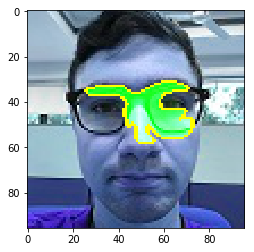

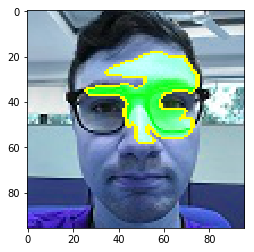

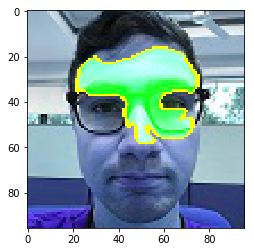

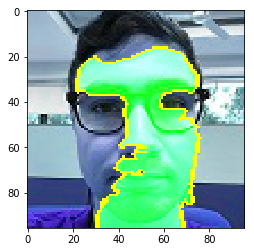

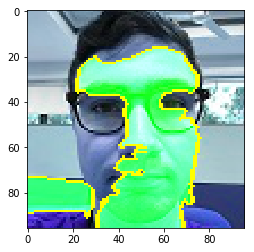

<Figure size 432x288 with 0 Axes>

In [300]:
get_explanation("images/greg_positive.jpg")

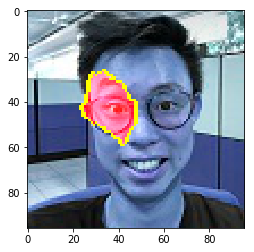

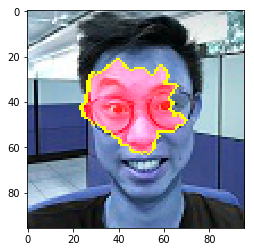

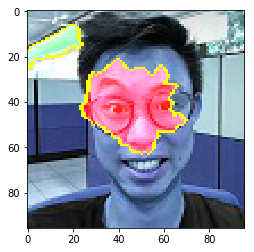

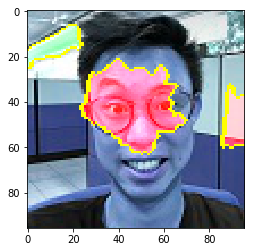

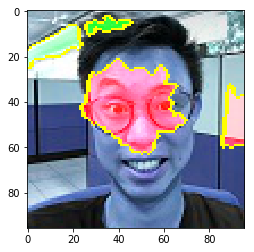

<Figure size 432x288 with 0 Axes>

In [295]:
get_explanation("images/maxim_positive.jpg")